# Project 1 CAP 6629


In this notebook, I explored the application of Q-learning to create an optimal policy for navigating a grid-world maze. The maze includes a start position, goal node, portals, and obstacles. The notebook explores the creation of each component required for the environment, agent, and Q table as well as experiments that were conducted to explore the training process, hyperparameters, and map.


Grid World Q-Learning

---

*Matthew Acs*

In [1]:
pip install pyfiglet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.3 MB/s eta 0:00:00


In [2]:
## Import necessary python packages
import numpy as np
import pyfiglet
from matplotlib import colors
from matplotlib import pyplot as plt
from prettytable import PrettyTable

## Environment

The code below defines the environment class. The environment class defines the maze and the functions associated with the maze. In a generalized Q-learning case, the environment provides three things: a map that allows an agent to move between states, a reward signal, and the next state given the current state and action. Therefore, the environment class that I defined only has one attribute, the map. The map contains an array that represents the grid world along with its walls, paths, goal node, and portals. I included two hard-coded portals that take the agent across the map if an agent moves into the space with the portal. This introduces a greater degree of complexity into the optimal policy that the agent must learn. The environment class also has two functions: interact, and display path. The interact function takes the current state of an agent along with an action and returns a reward and the next state. This is accomplished by applying the action to the current x and y coordinates of the agent and then analyzing the position that the agent ends up in. If the agent collides with a wall, its current position stays the same, but it receives a reward of -10. If the agent moves to an open path, it does not receive a reward, but it moves to the next space. If an agent moves to a portal, it goes to the exit portal and receives no reward. Finally, if an agent moves to the goal node, it receives a reward of 100 and the end-state flag is returned. The final function, display path, plots the map along with the path that the agent took given the agents history. This function utilizes matplotlib to graph the map and the agents action history. This makes it easy to visualize the path the agent would take based on the policy learned at different iterations.

In [3]:
class Environment:

  def __init__(self, x = 1, y = 9):
    """
    Initialize the Environment with a given maze.
    The goal node position can also be passed.
    """

    self.map = [
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0],
    [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0],
    [0, 1, 1, 0, 1, 1, 0, 3, 1, 1, 0],
    [0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0],
    [0, 1, 2, 0, 1, 1, 0, 1, 1, 4, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0],
    [0, 1, 5, 0, 1, 1, 1, 1, 1, 1, 0],
    [0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0],
    [0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    ]
    self.map[y][x] = 6

  def interact(self, action, x, y):
    """
    Simulate an agent's interaction with the environment and provide rewards and next states.

    Args:
      current_state: Current state of the agent represented as (x, y) coordinates.
      action: The action the agent intends to take.

    Returns:
      reward: The reward received after taking the given action.
      next_state: The next state the agent ends up in, represented as (x, y) coordinates.
    """

    x1 = x
    y1 = y

    if action == 0:
      x1 = x + 1
    elif action == 1:
      x1 = x - 1
    elif action == 2:
      y1 = y - 1
    elif action == 3:
      y1 = y + 1

    if self.map[y1][x1] == 0:
      return -10, x, y
    elif self.map[y1][x1] == 1:
      return 0, x1, y1
    elif self.map[y1][x1] == 2:
      return 0, 7, 3
    elif self.map[y1][x1] == 3:
      return 0, 2, 5
    elif self.map[y1][x1] == 4:
      return 0, 2, 7
    elif self.map[y1][x1] == 5:
      return 0, 9, 5
    elif self.map[y1][x1] == 6:
      return 100, -1, -1

  def display_path(self, path):
    """
    Display the map and the path the agent
    took using Matplotlib for visualization.

    Args:
      path: List of (x, y) coordinates
      representing the agent's action history.
    """

    cmap = colors.ListedColormap(['Black','white', 'blue', 'blue', 'purple', 'purple', 'green'])
    plt.figure(figsize=(6,6))
    plt.pcolor(self.map[::-1],cmap=cmap,edgecolors='k')

    x = [1.5]
    y = [9.5]
    for i in range(len(path)-1):
      x.append(path[i][0] + 0.5)
      y.append((10 - path[i][1]) + 0.5)
    plt.plot(x, y, "red")
    plt.axis('off')

    for i in range(9):
      text = str(i+1)

      x_coord = i + 1.5
      y_coord = 10.5
      plt.text(x_coord, y_coord, text, fontsize=12, ha='center', va='center', color='white')

      x_coord = 0.5
      y_coord = 9.5 - i
      plt.text(x_coord, y_coord, text, fontsize=12, ha='center', va='center', color='white')

    plt.show()


## Agent

The code below defines the agent class. The agent class contains attributes that are necessary to track the status of the agent through the learning process. The agent contains the current position, the location history of the agent for the current episode, the number of moves the agent took in the current episode, and the cumulative reward obtained by the agent in the current episode. The agent has two functions: move and reset. Move allows the agent to modify its current position, history, moves, and reward based on the next position and reward it obtained. Reset simply zeros the attributes of the agent so that the learning process can be repeated in the next episode.

In [4]:
class Agent:
  def __init__(self):
    """
    Initialize the Agent class with essential attributes
    for tracking its status during the learning process.

    Attributes:
      current position: The current position of the agent represented as (x, y) coordinates.
      location_history: The agent's location history for the current episode.
      moves: The number of moves the agent took in the current episode.
      cumulative reward: The cumulative reward obtained by the agent in the current episode.
    """

    self.x = 0
    self.y = 0
    self.history = []
    self.moves = 0
    self.cumulative_reward = 0

  def move(self, x, y, reward):
    """
    Update the agent's status based on the next position and reward obtained.

    Args:
      next position: The next position the agent will move to, represented as (x, y) coordinates.
      reward: The reward obtained by the agent for the current action.

    This function modifies the agent's current position, updates its location history,
    increments the move count, and accumulates the reward.
    """

    self.x = x
    self.y = y
    self.history.append([x,y])
    self.moves = self.moves+1
    self.cumulative_reward = self.cumulative_reward + reward

  def reset(self):
    """
    Reset the agent's attributes to prepare for the next episode.

    This function sets the agent's attributes to initial values,
    effectively resetting the agent for a new learning episode.
    """

    self.x = 0
    self.y = 0
    self.history = []
    self.moves = 0
    self.cumulative_reward = 0


## Q_Table

Finally, the Q-Table class is the main component of the learning process. The class contains three data attributes: an 11 by 11 by 4 array (Q-table), gamma, and alpha. These attributes are necessary parameters for the learning process to take place. The class also contains three functions: update, get action, and print table. The update function revises the q-table based on the current state, action, next state, and reward incurred by taking the action. The q-table entry for the current state-action pair is updated using the equation
Q(s,a) = (1-alpha) * Q(s, a) + alpha * ( R(s, a, s’) + gamma * max a’ Q(s’, a’)). The next function, get action, returns an action for the agent to take based on an epsilon-greedy strategy. The function takes the current position of the agent and epsilon and returns the next agent based on the epsilon-greedy strategy. The function returns a random action with probability epsilon and returns the action with the max q-values with probability 1-eplison. If the greedy action is chosen, the action is chosen randomly among all the greedy choices available. This get action function utilizes an epsilon greedy strategy to balance exploration and exploitation. If the policy is entirely greedy, it may get stuck in a local optimum due to a lack of exploration. On the other hand, an entirely random policy is computationally inefficient as it explores low-yield options with equal probability as high-yield options. Finally, the last function in the agent class is print table. The print table function utilizes the prettyTable python package to print the Q-table in a readable way so that it may be analyzed during different iterations of the training process.


In [5]:
class Q_Table:
  def __init__(self, gamma=0.5, alpha=0.5):
    """
    Initialize the QTable class with data attributes required for the learning process.

    Attributes:
      q_table: A 3D array representing the Q-table, with dimensions (11, 11, 4).
      gamma: The discount factor used in the Q-learning equation.
      alpha: The learning rate used in the Q-learning equation.
    """

    self.table = np.zeros((11, 11, 4))
    self.gamma = gamma
    self.alpha = alpha

  def update(self, x, y, action, x1, y1, reward):
    """
    Update the Q-table based on the current state, action, next state, and reward.

    Args:
      current state: The current state of the agent represented as (x, y) coordinates.
      action: The agent's chosen action.
      next state: The next state of the agent represented as (x, y) coordinates.
      reward: The reward obtained by the agent for the current action.

    This function updates the Q-value for the current state-action pair using the Q-learning equation.
    """

    self.table[x][y][action] = (1-self.alpha) * self.table[x][y][action] + self.alpha * (reward + self.gamma * np.max(self.table[x1][y1]))

  def get_action(self, epsilon, x, y):
    """
    Determine the action for the agent based on an epsilon-greedy strategy.

    Args:
      current state: The current state of the agent represented as (x, y) coordinates.
      epsilon: The exploration-exploitation trade-off factor.

    Returns:
      action: The selected action for the agent.

    This function implements an epsilon-greedy strategy, returning either a random action
    with probability epsilon or the action with the maximum Q-value with probability 1-epsilon.
    """

    rng = np.random.default_rng()

    if (rng.random() <= epsilon):
      return rng.integers(low=0, high=4)

    else:
      max = np.max(self.table[x][y])
      actions = []
      for i in range(4):
        if self.table[x][y][i]== max:
          actions.append(i)
      size = np.size(actions)
      random = rng.integers(low=0, high=size)
      return actions[random]

  def print_table(self):
    """
    Print the Q-table in a readable format using the PrettyTable Python package.

    This function facilitates the analysis of the Q-table during different iterations of the training process.
    """

    x = PrettyTable()
    x.field_names = ["Location", "Right", "Left", "Up", "Down"]

    for i in range(11):
      for j in range(11):
        x.add_row(["(" + str(i) + " , " + str(j) + ")", np.round(self.table[i][j][0],2), np.round(self.table[i][j][1],2), np.round(self.table[i][j][2],2), np.round(self.table[i][j][3],2)])

    print("Q-Table")
    print(x)



## Training Functions

The final five functions defined below are utilized in training the model as well as analyzing the training process. The q-learn function is the main training loop. It takes the number of iterations, a Q-table, maze, epsilon, gamma, and alpha, and trains the q table for the specified number of iterations. The agent is created for each iteration, and until the goal node is found, the agent picks an action using the epsilon-greedy strategy (get_action q-table function), interacts with the map to get a new state and reward (interact environment function), updates the q table (q-table update function), and moves the agent (agent move function). This process is repeated until the agents next position contains the goal node flag, at which point the episode is concluded. The agent is then reset, and the next episode is run. The process is repeated until the specified number of episodes have executed. Three arrays are returned by the training process: steps, rewards, and error. They specify the number of steps, cumulative reward, and TD error incurred by the agent for each training episode. The Q table passed to the function is also now updated according to the training process. The next function, trace, repeats one episode of the process in a greedy way without training the q table. In this way, the agents optimal path based on the learned policy can be returned so that the training process may be analyzed. The function convert to move, converts the internal integer codes for each move to an action, the function plot reward step plots the rewards/steps to go curve, and the plot error function plots the TD error across the training iterations.

In order to visualize the training process, the two plot functions were created. The rewards/steps-to-go graph shows the reward and steps taken for each iteration. The goal of the q-learning process is to obtain the greatest reward while minimizing the steps to obtain the greatest reward. Therefore, iterations with greater rewards and lower steps are approaching the optima while points deviating from that are not. This curve shows that as the iterations progress the reward increases and the steps decrease, demonstrating convergence of the training process. The error graph shows the TD error of the training process over time. The error I used was the sum of squared error of the TD error of the q-learning process. To obtain the TD error, I summed the squares of the differences of the Q before update and the Q after update divided by alpha for each update within an episode.

In [6]:
def q_learn(iterations, Q, maze, epsilon = 0.1, gamma = 0.5, alpha = 0.5):
  """
  Main training loop that updates the Q-table over a specified number of iterations.

  Args:
    iterations: The number of training iterations.
    q_table: The Q-table to be updated during training.
    maze: The environment with the maze structure.
    epsilon: The exploration-exploitation trade-off factor.
    gamma: The discount factor for future rewards.
    alpha: The learning rate for Q-table updates.

  Returns:
    steps, rewards, and error: Lists of steps, cumulative rewards, and error for each training episode.

  This function trains the Q-table over the specified number of iterations using Q-learning.
  An agent is created for each episode, and interactions with the environment are used to update the Q-table.
  Steps, rewards, and error for each episode are returned, along with the updated Q-table.
  """

  steps = []
  rewards = []
  errors = []
  for i in range (iterations):

    bob = Agent()
    bob.x = 1
    bob.y = 1
    error = 0
    flag = 0

    while flag != -1:
      action = Q.get_action(epsilon, bob.x, bob.y)
      q_value = Q.table[bob.x][bob.y][action]

      reward, x1, y1 = maze.interact(action, bob.x, bob.y)
      Q.update(bob.x, bob.y, action, x1, y1, reward)

      error = error + ((Q.table[bob.x][bob.y][action] - q_value)/alpha)**2
      bob.move(x1, y1, reward)

      flag = x1

    steps.append(bob.moves)
    rewards.append(bob.cumulative_reward)
    errors.append(error)

  return steps, rewards, errors

def trace(Q, maze):
  """
  Perform one episode of the Q-learning process without updating the Q-table.

  Args:
    q_table: The Q-table to guide the agent's actions.
    maze: The environment with the maze structure.

  Returns:
    path: A list of (x, y) coordinates representing the agent's path.

  This function simulates one episode in a greedy manner using the learned policy
  to return the agent's path based on the Q-table without further training.
  """

  bob = Agent()
  bob.x = 1
  bob.y = 1
  flag = 0

  actions = []

  while flag != -1:
    action = Q.get_action(0, bob.x, bob.y)
    actions.append(convert_to_move(action))

    reward, x1, y1 = maze.interact(action, bob.x, bob.y)
    bob.move(x1, y1, reward)
    flag = x1

  return actions, bob.moves, bob.cumulative_reward, bob.history

def convert_to_move(move):
  """
  Convert the internal integer codes for moves into human-readable actions.

  Args:
    action code: The internal integer code representing the agent's action.

  Returns:
    action: A human-readable action description.

  This function converts an action code into a human-readable action description.
  """

  if move == 0:
    return "right"
  elif move == 1:
    return "left"
  elif move == 2:
    return "up"
  elif move == 3:
    return "down"

def plot_reward_step(rewards, steps):
  """
  Plot the reward and steps during the training process.

  Args:
    steps: List of steps (number of moves) for each episode.
    rewards: List of cumulative rewards for each episode.

  This function creates a plot to visualize the relationship between rewards and steps across iterations during training.
  """

  plt.plot(rewards, label='Rewards')
  plt.plot(steps, label='Steps')

  plt.legend()
  plt.xlabel('Iterations')
  plt.ylabel('Value')

  plt.title('Rewards/Steps-To-Go')

def plot_error(error):
  """
  Plot the error across training iterations.

  Args:
    error: List of errors for each training iteration.

  This function generates a plot to visualize how the error changes across the training iterations.
  """

  plt.plot(error)

  plt.xlabel('Iterations')
  plt.ylabel('Error')

  plt.title('Sum of Squared Error')

---

## Experiments

The code cells below run various experiments to understand the training process and analyze how q-learning works to guide the agent to discover the optimal policy. The first set of experiments utilize a different number of iterations for training, then print the agents path based on the learned policy. The agent’s actions, steps, cumulative reward, and path are displayed as well as the map with the agent’s path. The reward-step graph and error graphs are also plotted, and the Q-table is printed.

### 1 Iteration

Agent Path Based on Learned Policy
----------------------------------
Actions: ['right', 'down', 'left', 'right', 'down', 'left', 'down', 'up', 'up', 'down', 'up', 'up', 'right', 'down', 'left', 'up', 'down', 'up', 'down', 'down', 'down', 'up', 'up', 'up', 'down', 'right', 'up', 'right', 'down', 'up', 'down', 'right', 'right', 'down', 'left', 'up', 'left', 'left', 'left', 'right', 'down', 'up', 'down', 'left', 'up', 'right', 'left', 'down', 'down', 'down', 'up', 'up', 'down', 'down', 'right', 'down', 'down', 'right', 'left', 'up', 'up', 'left', 'up', 'up', 'right', 'up', 'right', 'up', 'left', 'right', 'left', 'down', 'up', 'left', 'down', 'down', 'right', 'left', 'down', 'up', 'down', 'up', 'right', 'up', 'up', 'right', 'down', 'up', 'left', 'right', 'down', 'left', 'up', 'left', 'down', 'up', 'down', 'right', 'right', 'up', 'down', 'right', 'left', 'right', 'down', 'right', 'up', 'down', 'up', 'left', 'down', 'up', 'right', 'up', 'down', 'down', 'left', 'up', 'left', 'up', 'down', 'u

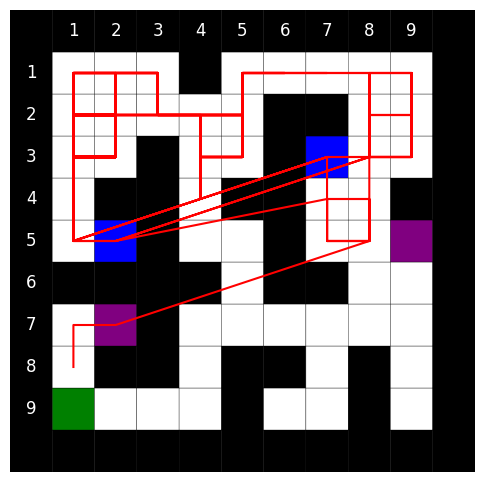

In [7]:
iterations = 1
epsilon = 0.1
q = Q_Table()
maze = Environment()

steps, rewards, error = q_learn(iterations, q, maze, epsilon)
a, s, r, h = trace(q, maze)

print("Agent Path Based on Learned Policy")
print("----------------------------------")
print("Actions: " + str(a))
print("Steps: " + str(s))
print("Reward: " + str(r))
print("Path: " + str(h))
print()

maze.display_path(h)

In [8]:
q.print_table()

Q-Table
+-----------+-------+-------+-------+-------+
|  Location | Right |  Left |   Up  |  Down |
+-----------+-------+-------+-------+-------+
|  (0 , 0)  |  0.0  |  0.0  |  0.0  |  0.0  |
|  (0 , 1)  |  0.0  |  0.0  |  0.0  |  0.0  |
|  (0 , 2)  |  0.0  |  0.0  |  0.0  |  0.0  |
|  (0 , 3)  |  0.0  |  0.0  |  0.0  |  0.0  |
|  (0 , 4)  |  0.0  |  0.0  |  0.0  |  0.0  |
|  (0 , 5)  |  0.0  |  0.0  |  0.0  |  0.0  |
|  (0 , 6)  |  0.0  |  0.0  |  0.0  |  0.0  |
|  (0 , 7)  |  0.0  |  0.0  |  0.0  |  0.0  |
|  (0 , 8)  |  0.0  |  0.0  |  0.0  |  0.0  |
|  (0 , 9)  |  0.0  |  0.0  |  0.0  |  0.0  |
|  (0 , 10) |  0.0  |  0.0  |  0.0  |  0.0  |
|  (1 , 0)  |  0.0  |  0.0  |  0.0  |  0.0  |
|  (1 , 1)  |  0.0  | -8.75 |  -5.0 |  0.0  |
|  (1 , 2)  |  0.0  |  -5.0 |  0.0  |  0.0  |
|  (1 , 3)  |  0.0  |  -7.5 |  0.0  |  0.0  |
|  (1 , 4)  |  -5.0 | -8.75 |  0.0  |  0.0  |
|  (1 , 5)  |  0.0  |  -5.0 |  0.0  |  -5.0 |
|  (1 , 6)  |  0.0  |  0.0  |  0.0  |  0.0  |
|  (1 , 7)  |  0.0  |  -5.

### 5 Iterations

Agent Path Based on Learned Policy
----------------------------------
Actions: ['down', 'up', 'down', 'up', 'down', 'down', 'right', 'left', 'right', 'left', 'up', 'right', 'down', 'left', 'up', 'down', 'down', 'up', 'down', 'up', 'right', 'up', 'up', 'left', 'down', 'right', 'up', 'left', 'right', 'down', 'up', 'right', 'down', 'right', 'down', 'right', 'down', 'up', 'up', 'down', 'down', 'up', 'left', 'right', 'left', 'down', 'right', 'up', 'up', 'right', 'left', 'right', 'right', 'left', 'right', 'right', 'down', 'up', 'left', 'right', 'down', 'down', 'up', 'up', 'left', 'left', 'right', 'left', 'left', 'down', 'up', 'down', 'down', 'up', 'up', 'down', 'up', 'right', 'right', 'right', 'right', 'down', 'up', 'left', 'down', 'down', 'up', 'up', 'right', 'left', 'left', 'left', 'left', 'down', 'down', 'up', 'down', 'down', 'up', 'up', 'right', 'left', 'down', 'left', 'right', 'down', 'left', 'down', 'up', 'right', 'left', 'up', 'down', 'right', 'left', 'up', 'down', 'right', 'down', 'l

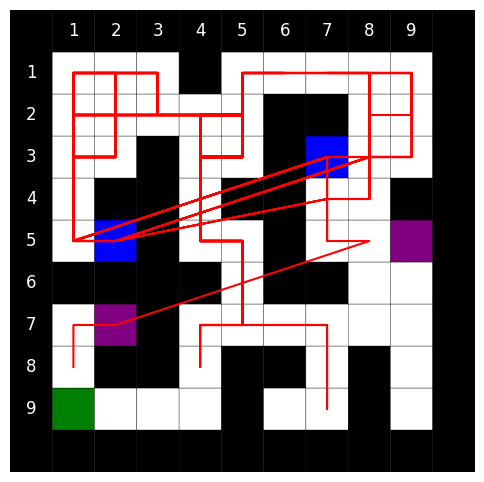

In [9]:
iterations = 5
epsilon = 0.1
q = Q_Table()
maze = Environment()

steps, rewards, error = q_learn(iterations, q, maze, epsilon)
a, s, r, h = trace(q, maze)

print("Agent Path Based on Learned Policy")
print("----------------------------------")
print("Actions: " + str(a))
print("Steps: " + str(s))
print("Reward: " + str(r))
print("Path: " + str(h))
print()

maze.display_path(h)

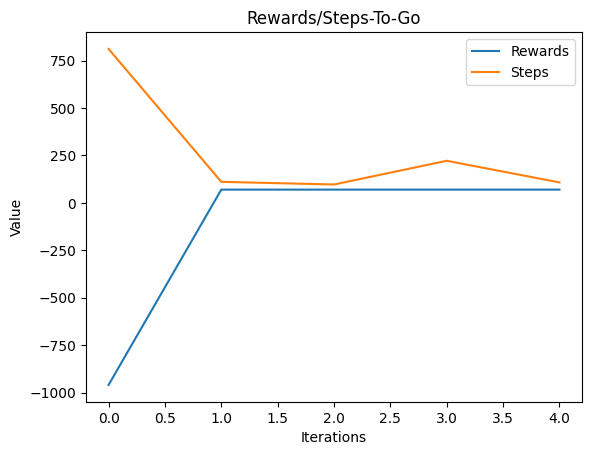

In [10]:
plot_reward_step(rewards, steps)

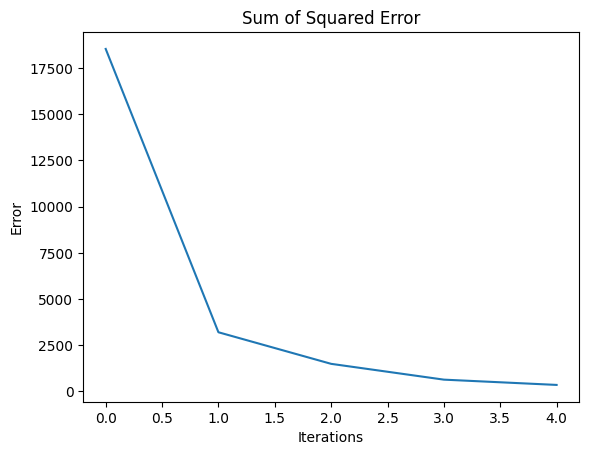

In [11]:
plot_error(error)

In [12]:
q.print_table()

Q-Table
+-----------+-------+-------+-------+-------+
|  Location | Right |  Left |   Up  |  Down |
+-----------+-------+-------+-------+-------+
|  (0 , 0)  |  0.0  |  0.0  |  0.0  |  0.0  |
|  (0 , 1)  |  0.0  |  0.0  |  0.0  |  0.0  |
|  (0 , 2)  |  0.0  |  0.0  |  0.0  |  0.0  |
|  (0 , 3)  |  0.0  |  0.0  |  0.0  |  0.0  |
|  (0 , 4)  |  0.0  |  0.0  |  0.0  |  0.0  |
|  (0 , 5)  |  0.0  |  0.0  |  0.0  |  0.0  |
|  (0 , 6)  |  0.0  |  0.0  |  0.0  |  0.0  |
|  (0 , 7)  |  0.0  |  0.0  |  0.0  |  0.0  |
|  (0 , 8)  |  0.0  |  0.0  |  0.0  |  0.0  |
|  (0 , 9)  |  0.0  |  0.0  |  0.0  |  0.0  |
|  (0 , 10) |  0.0  |  0.0  |  0.0  |  0.0  |
|  (1 , 0)  |  0.0  |  0.0  |  0.0  |  0.0  |
|  (1 , 1)  |  0.0  |  -7.5 |  -5.0 |  0.0  |
|  (1 , 2)  |  0.0  | -9.38 |  0.0  |  0.0  |
|  (1 , 3)  |  0.0  |  -5.0 |  0.0  |  0.0  |
|  (1 , 4)  |  -5.0 |  -5.0 |  0.0  |  0.0  |
|  (1 , 5)  |  0.0  |  -5.0 |  0.0  |  -5.0 |
|  (1 , 6)  |  0.0  |  0.0  |  0.0  |  0.0  |
|  (1 , 7)  |  0.0  |  -5.

### 10 Iterations

Agent Path Based on Learned Policy
----------------------------------
Actions: ['right', 'down', 'right', 'up', 'down', 'up', 'down', 'up', 'left', 'down', 'right', 'up', 'down', 'left', 'left', 'down', 'right', 'up', 'left', 'down', 'right', 'left', 'down', 'down', 'right', 'right', 'down', 'down', 'right', 'left', 'down', 'down']
Steps: 32
Reward: 100
Path: [[2, 1], [2, 2], [3, 2], [3, 1], [3, 2], [3, 1], [3, 2], [3, 1], [2, 1], [2, 2], [3, 2], [3, 1], [3, 2], [2, 2], [1, 2], [1, 3], [2, 3], [2, 2], [1, 2], [1, 3], [2, 3], [1, 3], [1, 4], [1, 5], [7, 3], [8, 3], [8, 4], [8, 5], [2, 7], [1, 7], [1, 8], [-1, -1]]



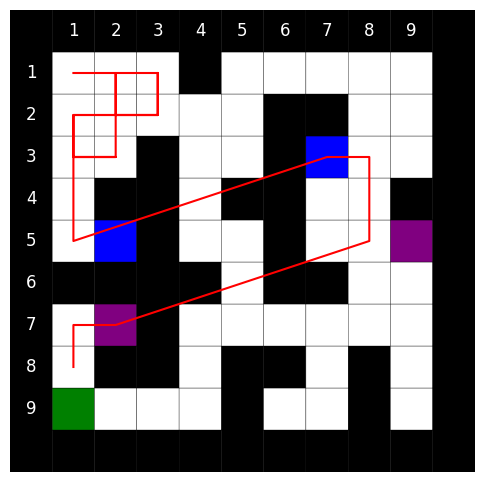

In [13]:
iterations = 10
epsilon = 0.1
q = Q_Table()
maze = Environment()

steps, rewards, error = q_learn(iterations, q, maze, epsilon)
a, s, r, h = trace(q, maze)

print("Agent Path Based on Learned Policy")
print("----------------------------------")
print("Actions: " + str(a))
print("Steps: " + str(s))
print("Reward: " + str(r))
print("Path: " + str(h))
print()

maze.display_path(h)

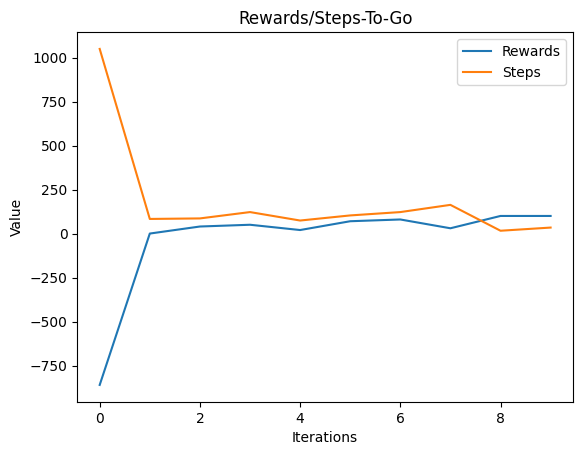

In [14]:
plot_reward_step(rewards, steps)

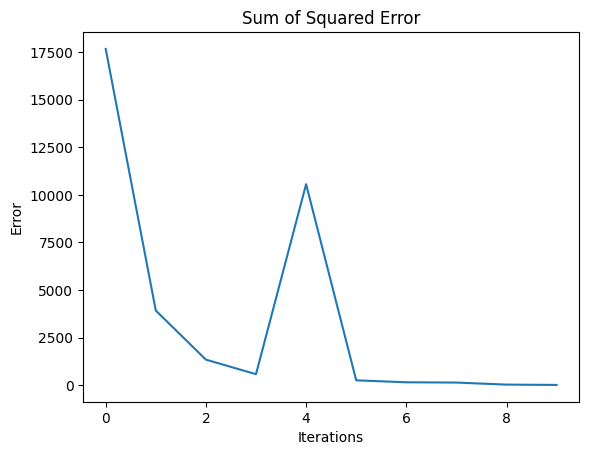

In [15]:
plot_error(error)

In [16]:
q.print_table()

Q-Table
+-----------+-------+-------+-------+-------+
|  Location | Right |  Left |   Up  |  Down |
+-----------+-------+-------+-------+-------+
|  (0 , 0)  |  0.0  |  0.0  |  0.0  |  0.0  |
|  (0 , 1)  |  0.0  |  0.0  |  0.0  |  0.0  |
|  (0 , 2)  |  0.0  |  0.0  |  0.0  |  0.0  |
|  (0 , 3)  |  0.0  |  0.0  |  0.0  |  0.0  |
|  (0 , 4)  |  0.0  |  0.0  |  0.0  |  0.0  |
|  (0 , 5)  |  0.0  |  0.0  |  0.0  |  0.0  |
|  (0 , 6)  |  0.0  |  0.0  |  0.0  |  0.0  |
|  (0 , 7)  |  0.0  |  0.0  |  0.0  |  0.0  |
|  (0 , 8)  |  0.0  |  0.0  |  0.0  |  0.0  |
|  (0 , 9)  |  0.0  |  0.0  |  0.0  |  0.0  |
|  (0 , 10) |  0.0  |  0.0  |  0.0  |  0.0  |
|  (1 , 0)  |  0.0  |  0.0  |  0.0  |  0.0  |
|  (1 , 1)  |  0.0  |  -7.5 | -8.75 |  0.0  |
|  (1 , 2)  |  0.0  | -8.75 |  0.0  |  0.0  |
|  (1 , 3)  |  0.0  | -8.75 |  0.0  |  0.0  |
|  (1 , 4)  | -9.38 | -8.75 |  0.0  |  0.0  |
|  (1 , 5)  |  0.02 | -8.75 |  0.0  |  -7.5 |
|  (1 , 6)  |  0.0  |  0.0  |  0.0  |  0.0  |
|  (1 , 7)  |  0.0  |  -5.

### 100 Iterations

Agent Path Based on Learned Policy
----------------------------------
Actions: ['down', 'down', 'down', 'down', 'right', 'right', 'down', 'down', 'right', 'left', 'down', 'down']
Steps: 12
Reward: 100
Path: [[1, 2], [1, 3], [1, 4], [1, 5], [7, 3], [8, 3], [8, 4], [8, 5], [2, 7], [1, 7], [1, 8], [-1, -1]]



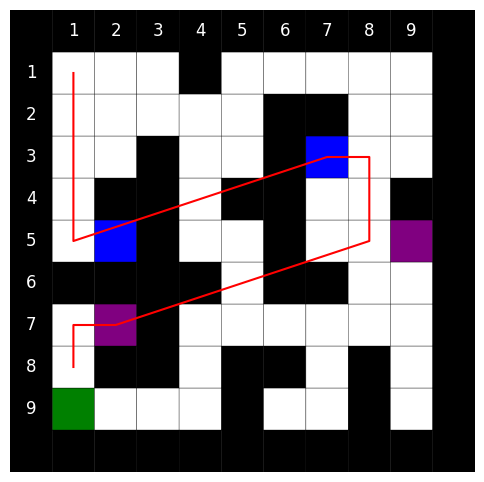

In [17]:
iterations = 100
epsilon = 0.1
q = Q_Table()
maze = Environment()

steps, rewards, error = q_learn(iterations, q, maze, epsilon)
a, s, r, h = trace(q, maze)

print("Agent Path Based on Learned Policy")
print("----------------------------------")
print("Actions: " + str(a))
print("Steps: " + str(s))
print("Reward: " + str(r))
print("Path: " + str(h))
print()

maze.display_path(h)

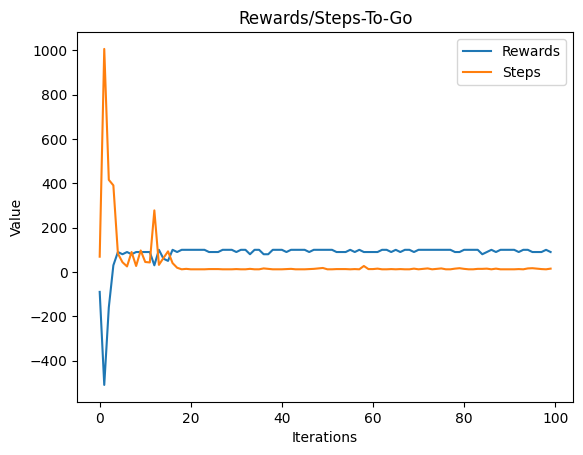

In [18]:
plot_reward_step(rewards, steps)

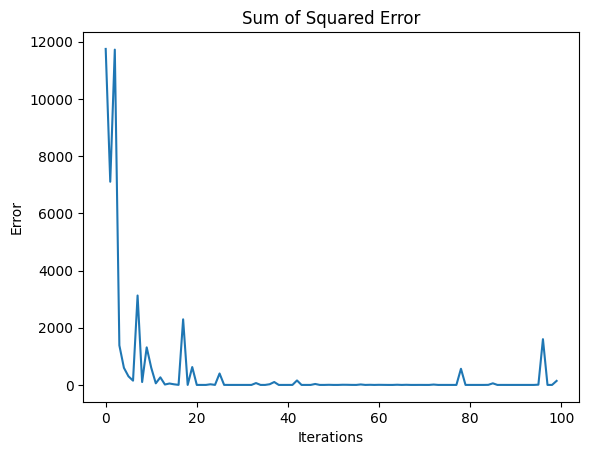

In [19]:
plot_error(error)

In [20]:
q.print_table()

Q-Table
+-----------+-------+-------+-------+-------+
|  Location | Right |  Left |   Up  |  Down |
+-----------+-------+-------+-------+-------+
|  (0 , 0)  |  0.0  |  0.0  |  0.0  |  0.0  |
|  (0 , 1)  |  0.0  |  0.0  |  0.0  |  0.0  |
|  (0 , 2)  |  0.0  |  0.0  |  0.0  |  0.0  |
|  (0 , 3)  |  0.0  |  0.0  |  0.0  |  0.0  |
|  (0 , 4)  |  0.0  |  0.0  |  0.0  |  0.0  |
|  (0 , 5)  |  0.0  |  0.0  |  0.0  |  0.0  |
|  (0 , 6)  |  0.0  |  0.0  |  0.0  |  0.0  |
|  (0 , 7)  |  0.0  |  0.0  |  0.0  |  0.0  |
|  (0 , 8)  |  0.0  |  0.0  |  0.0  |  0.0  |
|  (0 , 9)  |  0.0  |  0.0  |  0.0  |  0.0  |
|  (0 , 10) |  0.0  |  0.0  |  0.0  |  0.0  |
|  (1 , 0)  |  0.0  |  0.0  |  0.0  |  0.0  |
|  (1 , 1)  |  0.0  | -9.68 | -9.83 |  0.05 |
|  (1 , 2)  |  0.0  | -9.34 |  0.01 |  0.1  |
|  (1 , 3)  |  0.01 |  -9.6 |  0.02 |  0.2  |
|  (1 , 4)  | -9.68 | -9.55 |  0.09 |  0.39 |
|  (1 , 5)  |  0.78 | -9.35 |  0.18 | -9.08 |
|  (1 , 6)  |  0.0  |  0.0  |  0.0  |  0.0  |
|  (1 , 7)  |  0.76 |  -5.

### 100,000 Iterations

Agent Path Based on Learned Policy
----------------------------------
Actions: ['down', 'down', 'down', 'down', 'right', 'down', 'down', 'right', 'right', 'left', 'down', 'down']
Steps: 12
Reward: 100
Path: [[1, 2], [1, 3], [1, 4], [1, 5], [7, 3], [7, 4], [7, 5], [8, 5], [2, 7], [1, 7], [1, 8], [-1, -1]]



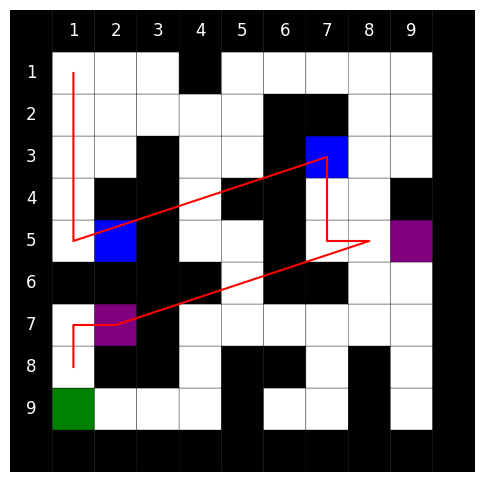

In [21]:
iterations = 100000
epsilon = 0.1
q = Q_Table()
maze = Environment()

steps, rewards, error = q_learn(iterations, q, maze, epsilon)
a, s, r, h = trace(q, maze)

print("Agent Path Based on Learned Policy")
print("----------------------------------")
print("Actions: " + str(a))
print("Steps: " + str(s))
print("Reward: " + str(r))
print("Path: " + str(h))
print()

maze.display_path(h)

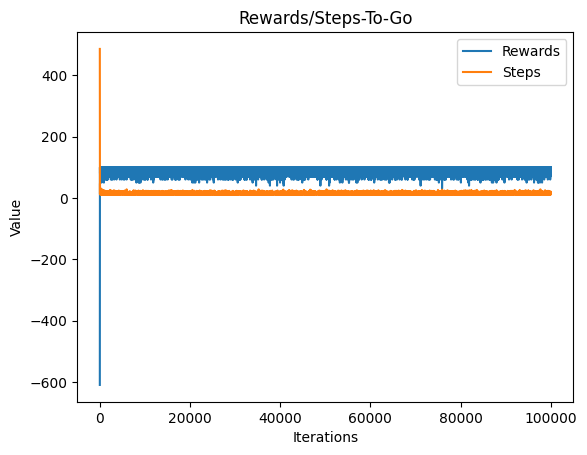

In [22]:
plot_reward_step(rewards, steps)

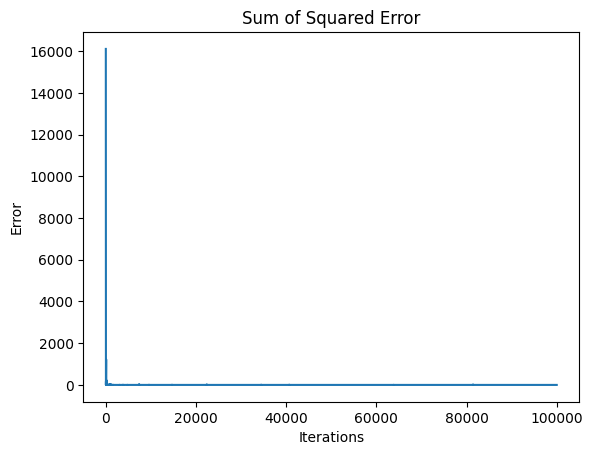

In [23]:
plot_error(error)

In [24]:
q.print_table()

Q-Table
+-----------+-------+-------+-------+-------+
|  Location | Right |  Left |   Up  |  Down |
+-----------+-------+-------+-------+-------+
|  (0 , 0)  |  0.0  |  0.0  |  0.0  |  0.0  |
|  (0 , 1)  |  0.0  |  0.0  |  0.0  |  0.0  |
|  (0 , 2)  |  0.0  |  0.0  |  0.0  |  0.0  |
|  (0 , 3)  |  0.0  |  0.0  |  0.0  |  0.0  |
|  (0 , 4)  |  0.0  |  0.0  |  0.0  |  0.0  |
|  (0 , 5)  |  0.0  |  0.0  |  0.0  |  0.0  |
|  (0 , 6)  |  0.0  |  0.0  |  0.0  |  0.0  |
|  (0 , 7)  |  0.0  |  0.0  |  0.0  |  0.0  |
|  (0 , 8)  |  0.0  |  0.0  |  0.0  |  0.0  |
|  (0 , 9)  |  0.0  |  0.0  |  0.0  |  0.0  |
|  (0 , 10) |  0.0  |  0.0  |  0.0  |  0.0  |
|  (1 , 0)  |  0.0  |  0.0  |  0.0  |  0.0  |
|  (1 , 1)  |  0.01 | -9.98 | -9.98 |  0.05 |
|  (1 , 2)  |  0.02 | -9.95 |  0.02 |  0.1  |
|  (1 , 3)  |  0.05 |  -9.9 |  0.05 |  0.2  |
|  (1 , 4)  |  -9.8 |  -9.8 |  0.1  |  0.39 |
|  (1 , 5)  |  0.78 | -9.61 |  0.2  | -9.61 |
|  (1 , 6)  |  0.0  |  0.0  |  0.0  |  0.0  |
|  (1 , 7)  |  3.12 |  15.

### Changing the map

The next set of experiments change the map to demonstrate that the q-learning process works regardless of the location of the goal node. The goal node’s location is moved around the map and the agent’s path based on the learned policy is shown.

Agent Path Based on Learned Policy
----------------------------------
Actions: ['down', 'down', 'down', 'down', 'right', 'right', 'down', 'down', 'down', 'right', 'down', 'down', 'down']
Steps: 13
Reward: 100
Path: [[1, 2], [1, 3], [1, 4], [1, 5], [7, 3], [8, 3], [8, 4], [8, 5], [8, 6], [9, 6], [9, 7], [9, 8], [-1, -1]]



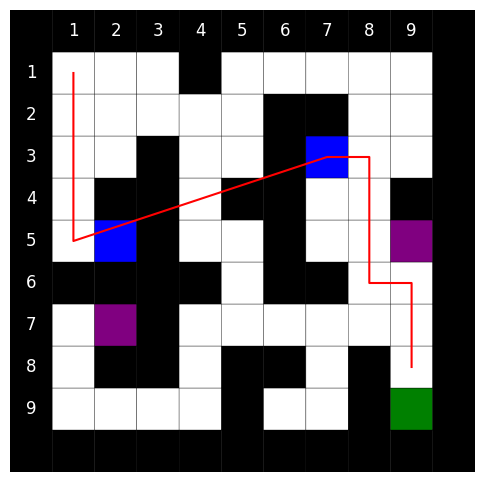

In [25]:
iterations = 10000
epsilon = 0.3
q = Q_Table()
maze = Environment(9,9)

steps, rewards, error = q_learn(iterations, q, maze, epsilon)
a, s, r, h = trace(q, maze)

print("Agent Path Based on Learned Policy")
print("----------------------------------")
print("Actions: " + str(a))
print("Steps: " + str(s))
print("Reward: " + str(r))
print("Path: " + str(h))
print()

maze.display_path(h)

Agent Path Based on Learned Policy
----------------------------------
Actions: ['down', 'down', 'down', 'down', 'right', 'right', 'up', 'right', 'up']
Steps: 9
Reward: 100
Path: [[1, 2], [1, 3], [1, 4], [1, 5], [7, 3], [8, 3], [8, 2], [9, 2], [-1, -1]]



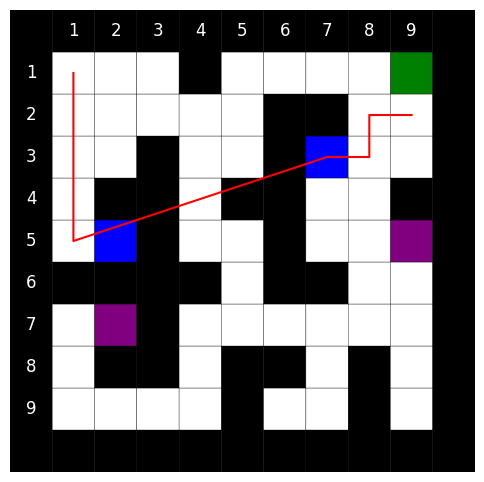

In [26]:
iterations = 10000
epsilon = 0.3
q = Q_Table()
maze = Environment(9,1)

steps, rewards, error = q_learn(iterations, q, maze, epsilon)
a, s, r, h = trace(q, maze)

print("Agent Path Based on Learned Policy")
print("----------------------------------")
print("Actions: " + str(a))
print("Steps: " + str(s))
print("Reward: " + str(r))
print("Path: " + str(h))
print()

maze.display_path(h)

Agent Path Based on Learned Policy
----------------------------------
Actions: ['right', 'right', 'down', 'right', 'down', 'down', 'down', 'right']
Steps: 8
Reward: 100
Path: [[2, 1], [3, 1], [3, 2], [4, 2], [4, 3], [4, 4], [4, 5], [-1, -1]]



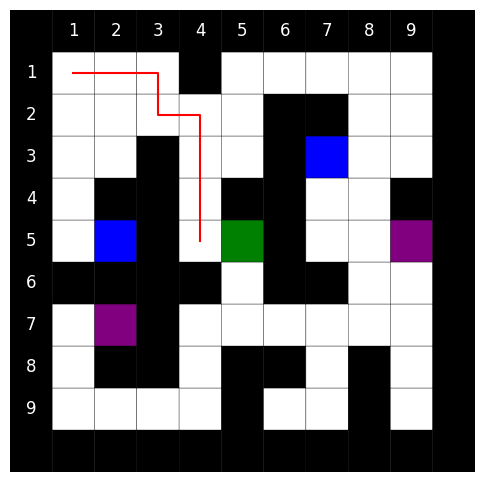

In [27]:
iterations = 10000
epsilon = 0.3
q = Q_Table()
maze = Environment(5,5)

steps, rewards, error = q_learn(iterations, q, maze, epsilon)
a, s, r, h = trace(q, maze)

print("Agent Path Based on Learned Policy")
print("----------------------------------")
print("Actions: " + str(a))
print("Steps: " + str(s))
print("Reward: " + str(r))
print("Path: " + str(h))
print()

maze.display_path(h)

### Changing Epsilon

Finally, the last set of experiments modify epsilon to show how the training process is impacted by the exploration-exploitation balance. Epsilon is set to 0, 0.4, 0.7, and 1. The path is shown on the map as well as the error curve.

Agent Path Based on Learned Policy
----------------------------------
Actions: ['down', 'down', 'down', 'down', 'right', 'down', 'right', 'down', 'right', 'left', 'down', 'down']
Steps: 12
Reward: 100
Path: [[1, 2], [1, 3], [1, 4], [1, 5], [7, 3], [7, 4], [8, 4], [8, 5], [2, 7], [1, 7], [1, 8], [-1, -1]]



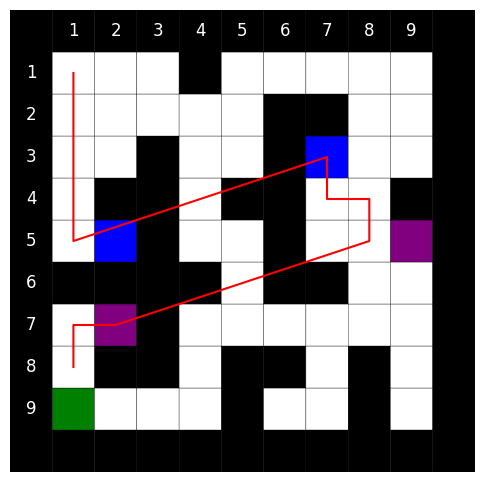

In [28]:
iterations = 100
epsilon = 0
q = Q_Table()
maze = Environment()

steps, rewards, error = q_learn(iterations, q, maze, epsilon)
a, s, r, h = trace(q, maze)

print("Agent Path Based on Learned Policy")
print("----------------------------------")
print("Actions: " + str(a))
print("Steps: " + str(s))
print("Reward: " + str(r))
print("Path: " + str(h))
print()

maze.display_path(h)

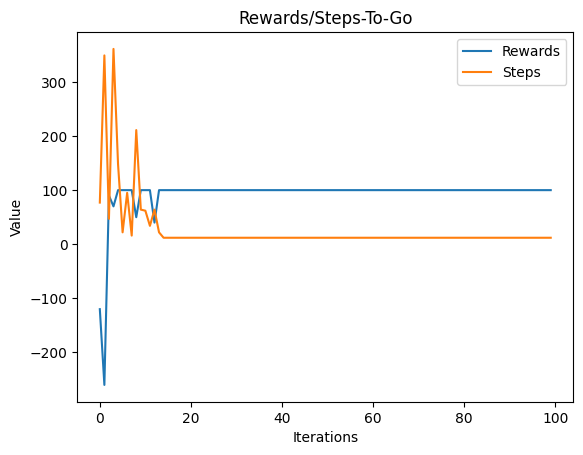

In [29]:
plot_reward_step(rewards, steps)

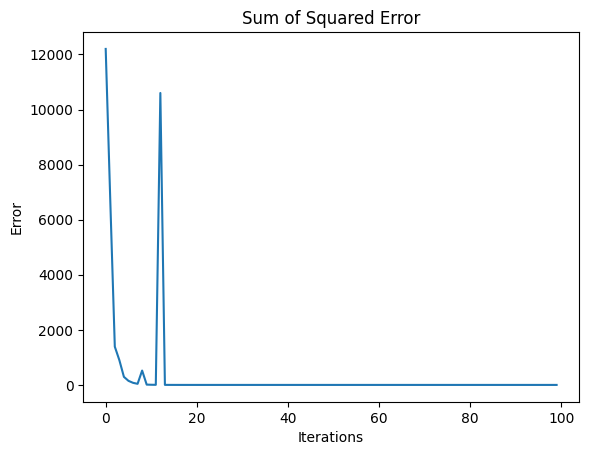

In [30]:
plot_error(error)

Agent Path Based on Learned Policy
----------------------------------
Actions: ['down', 'down', 'down', 'down', 'right', 'down', 'down', 'right', 'right', 'left', 'down', 'down']
Steps: 12
Reward: 100
Path: [[1, 2], [1, 3], [1, 4], [1, 5], [7, 3], [7, 4], [7, 5], [8, 5], [2, 7], [1, 7], [1, 8], [-1, -1]]



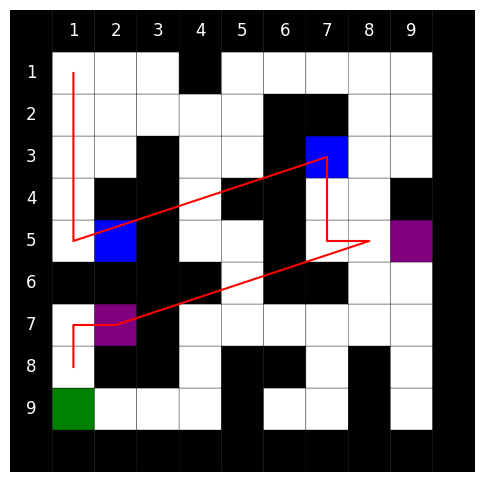

In [31]:
iterations = 100
epsilon = 0.4
q = Q_Table()
maze = Environment()

steps, rewards, error = q_learn(iterations, q, maze, epsilon)
a, s, r, h = trace(q, maze)

print("Agent Path Based on Learned Policy")
print("----------------------------------")
print("Actions: " + str(a))
print("Steps: " + str(s))
print("Reward: " + str(r))
print("Path: " + str(h))
print()

maze.display_path(h)

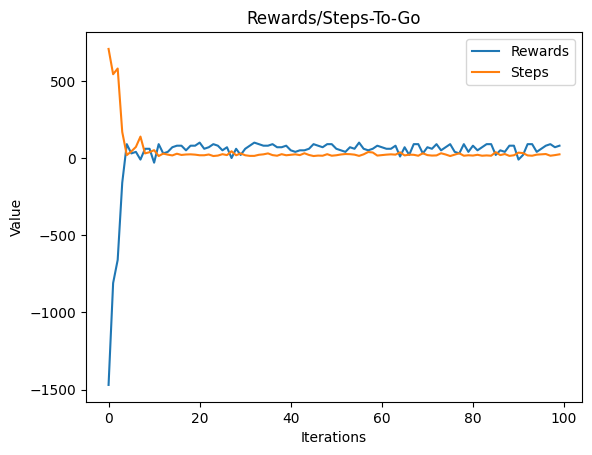

In [32]:
plot_reward_step(rewards, steps)

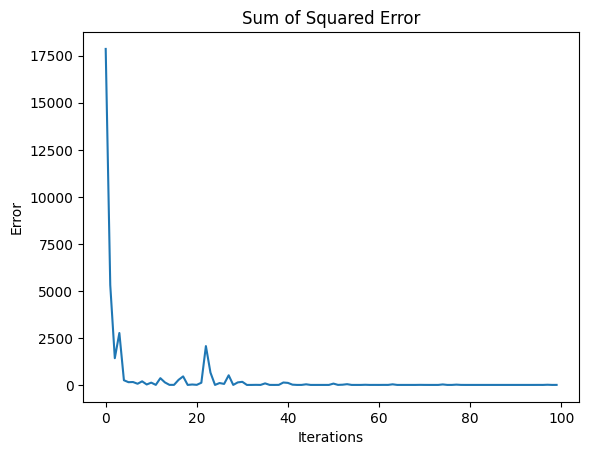

In [33]:
plot_error(error)

Agent Path Based on Learned Policy
----------------------------------
Actions: ['down', 'down', 'down', 'down', 'right', 'right', 'down', 'down', 'right', 'left', 'down', 'down']
Steps: 12
Reward: 100
Path: [[1, 2], [1, 3], [1, 4], [1, 5], [7, 3], [8, 3], [8, 4], [8, 5], [2, 7], [1, 7], [1, 8], [-1, -1]]



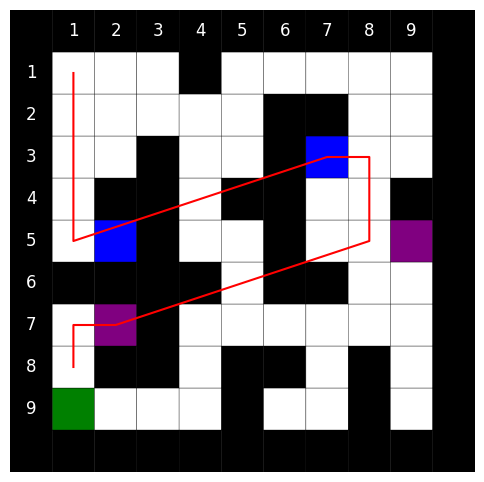

In [34]:
iterations = 100
epsilon = 0.7
q = Q_Table()
maze = Environment()

steps, rewards, error = q_learn(iterations, q, maze, epsilon)
a, s, r, h = trace(q, maze)

print("Agent Path Based on Learned Policy")
print("----------------------------------")
print("Actions: " + str(a))
print("Steps: " + str(s))
print("Reward: " + str(r))
print("Path: " + str(h))
print()

maze.display_path(h)

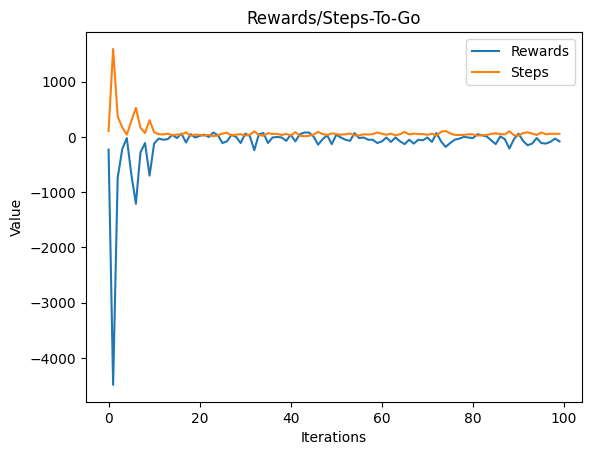

In [35]:
plot_reward_step(rewards, steps)

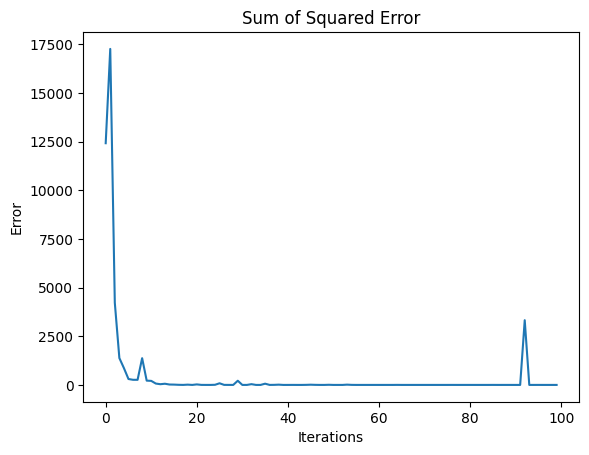

In [36]:
plot_error(error)

Agent Path Based on Learned Policy
----------------------------------
Actions: ['down', 'down', 'down', 'down', 'right', 'right', 'down', 'down', 'right', 'left', 'down', 'down']
Steps: 12
Reward: 100
Path: [[1, 2], [1, 3], [1, 4], [1, 5], [7, 3], [8, 3], [8, 4], [8, 5], [2, 7], [1, 7], [1, 8], [-1, -1]]



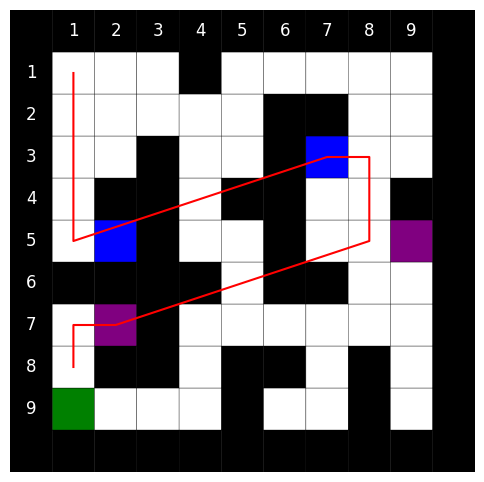

In [37]:
iterations = 100
epsilon = 1
q = Q_Table()
maze = Environment()

steps, rewards, error = q_learn(iterations, q, maze, epsilon)
a, s, r, h = trace(q, maze)

print("Agent Path Based on Learned Policy")
print("----------------------------------")
print("Actions: " + str(a))
print("Steps: " + str(s))
print("Reward: " + str(r))
print("Path: " + str(h))
print()

maze.display_path(h)

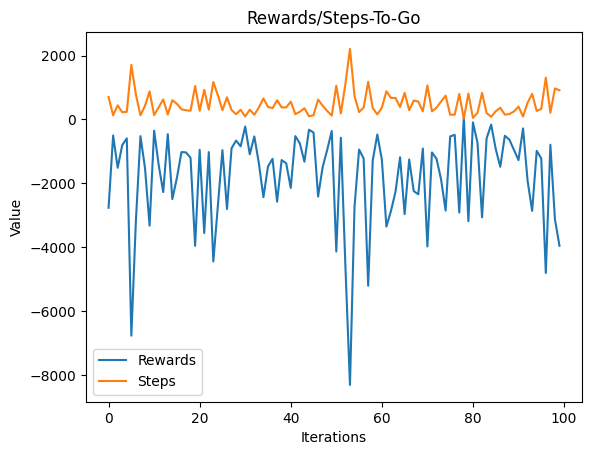

In [38]:
plot_reward_step(rewards, steps)

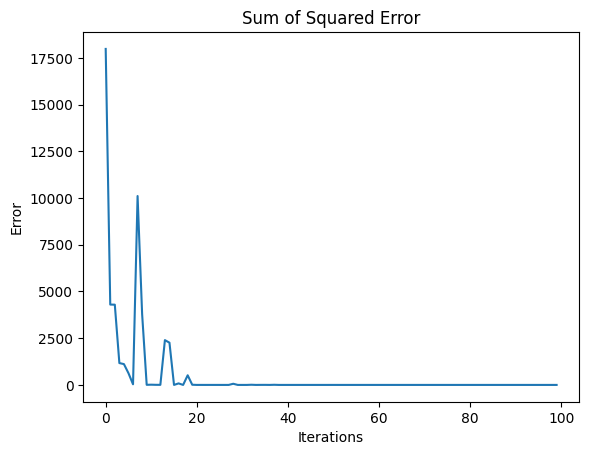

In [39]:
plot_error(error)

## Discussions and Conclusions

Overall, the notebook showed that a Q-learning algorithm can be created to find the optimal path in a gridworld with obstacles. The different experiments highlighted the training process and showed the convergence of the Q-table, and the different maps highlighted that the Q-learning process can work for the general case of any grid-world. The Q-learning algorithm was able to find the optimal policy in the experiments and the plots, visualizations, and Q-tables showed how the Q table learned the optimal policy throughout the training process.

### Convergence Across Iterations

The error curve, rewards/steps to go curve, path visualizations, and Q tables all highlighted how the Q-learning algorithm converged to an optimum over time. When only 1 iteration of training occurred, the agent’s path was quite random, with a high number of steps and a low reward. After 5 iterations, the steps decreased and the reward increased, but the agent’s path was still quite random. This is due to the fact that the information from the goal node was not able to propagate across the map yet. While the error did start to decrease by 5 iterations, the rewards and steps did not make substantial progress in converging to the optima. After 10 iterations, a similar trend is present, however, the error decreased substantially, and the rewards/steps began to converge to the optima. The path taken after 10 iterations is less random, but near the start node it is still not optimal. After 100 iterations, the learning algorithms seems to converge. The optimal path is found, the rewards/steps to go graph shows that the rewards and steps converged to near their optima, and the error decreased substantially and started to stagnate. Finally, after 100,000 iterations this trend is solidified, indicating convergence. The reward/steps for each iteration have stagnated and the error has stagnated. It is important to note that the rewards and steps have a degree of stochasticity due to the epsilon greedy method that was implemented for training. The Q-tables parallel the trend explained by the visualizations. Q-tables trained with less iterations have less of the table filled out, and the values have not yet converged. After around 100,000 iterations, the high-yield parts of the table have been filled out with values that have converged.

### Changing the Map

To demonstrate that the Q-learning algorithm is independent of the specific map setup, I created a few different maps to test the algorithm on. After 10,000 iterations each trial converged to the optimal policy despite different goal node locations. It is interesting to see how the algorithm learns to use the portals to access different portions of the map more efficiently.

### Exploitation vs Exploration

Finally, I changed the epsilon parameter to show how the change in exploration-exploitation balance changes the learning process. Notably, despite the range of epsilon values, the algorithm still converged to the optimal path on all trials (on this code execution). However, lower epsilon values resulted in an error curve that converged to the minimum error faster than higher epsilon values. Additionally, the rewards/step curve becomes more random at higher epsilon values. With epsilon = 0, the rewards/step curve converges to the optimal values, while at epsilon = 1, the curve is entirely random. This makes sense because at higher epsilon values the agent ignores the information learned in the Q-table when picking an action. Thus, the agent will take more steps and get a smaller reward when it has a higher epsilon value and acts more randomly. This also incurs a higher error in the beginning because it means the Q-table is filled out in low-yield areas as well as high-yield areas, which takes longer to converge. The advantage of a higher epsilon value is that it will not get stuck in a local optimum. With an epsilon value of 0, there is a chance that the algorithm will not find the best path because it will not explore the map. With an epsilon value of 1, the entire map will be explored, ensuring that the algorithm will not get stuck in a local optimum. However, at higher epsilon values the algorithm takes much longer to execute.

In [40]:
text = "Matthew Acs"
font = pyfiglet.Figlet()
word_art = font.renderText(text)
print(word_art)

 __  __       _   _   _                        _            
|  \/  | __ _| |_| |_| |__   _____      __    / \   ___ ___ 
| |\/| |/ _` | __| __| '_ \ / _ \ \ /\ / /   / _ \ / __/ __|
| |  | | (_| | |_| |_| | | |  __/\ V  V /   / ___ \ (__\__ \
|_|  |_|\__,_|\__|\__|_| |_|\___| \_/\_/   /_/   \_\___|___/
                                                            

